## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal

def rgb2gray(rgb_image):
    return np.dot(rgb_image[...,:3], [0.299, 0.587, 0.114])

## Load Image

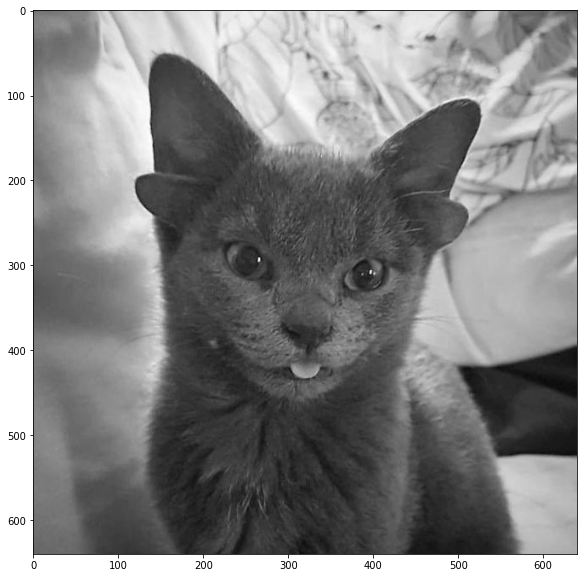

In [2]:
image = mpimg.imread("images/cat.jpeg")
image_gr = rgb2gray(image)

figureSize = (12,10)
plt.figure("Original Image", figsize=figureSize)
plt.imshow(image_gr)
plt.set_cmap("gray")

## Add Noise

## Gaussian Filter

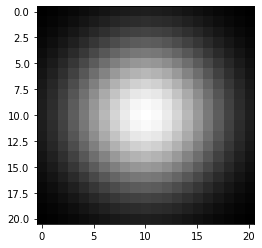

In [3]:
def gaussian_kernel( kernlen , std ):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

plt.imshow(gaussian_kernel(21,5), interpolation='none')

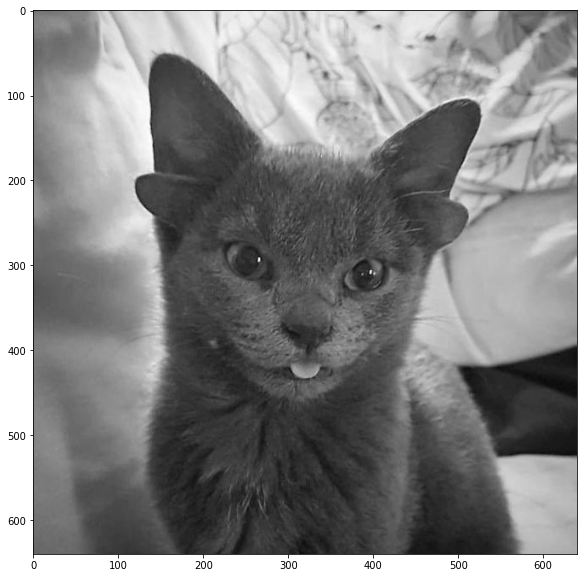

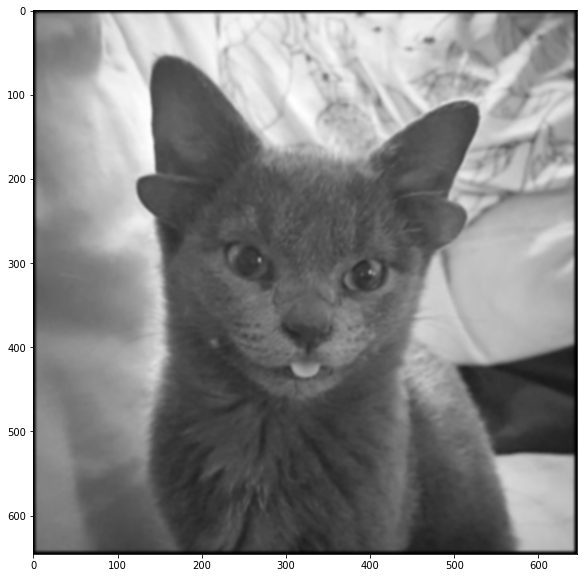

In [4]:
def gaussian_smooth(img, kernel_dim, std):
    return signal.convolve2d(img, gaussian_kernel(kernel_dim, std))

plt.figure("Noised", figsize = figureSize)
plt.imshow(image_gr)

plt.figure("Smoothed", figsize = figureSize)
plt.imshow(gaussian_smooth(image_gr, 7, 1.5))

## Gaussian Filter

[[0.01129742 0.03081745 0.06079643 ... 0.05183019 0.02631234 0.00965145]
 [0.03099625 0.07964372 0.14846105 ... 0.1267708  0.0681182  0.02652653]
 [0.06157186 0.14948213 0.26019865 ... 0.22277369 0.12818277 0.05282885]
 ...
 [0.05922676 0.14400453 0.25014738 ... 0.39190754 0.22640014 0.09362322]
 [0.03006667 0.07743721 0.14430311 ... 0.22603315 0.12174232 0.04752645]
 [0.01103063 0.03018225 0.05959537 ... 0.09334891 0.04746418 0.01744027]]


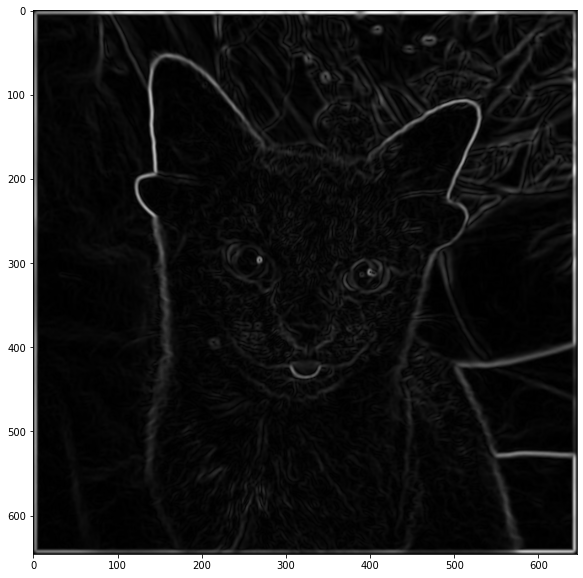

In [5]:
sobel_x = np.array([[ -1 , 0 , 1 ] ,
                    [ -2 , 0 , 2 ] ,
                    [ -1 , 0 , 1 ]])
sobel_y = sobel_x.T

def gradient_sobel(img):
    I_x = signal.convolve2d(img, sobel_x,'same')
    I_y = signal.convolve2d(img, sobel_y,'same')
    magnitude = np.sqrt(I_x ** 2 + I_y ** 2)    
    phase = np.arctan2(I_x, I_y)
    phase = (45 * np.round(phase / (np.pi / 4)) + 180) % 180
    return magnitude, phase

def normalize(img):
    maxi = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] > maxi:
                maxi = img[i][j]
    newimg = np.zeros(img.shape)
    if maxi == 0 :
        return img
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            newimg[i][j] = (img[i][j]/maxi)
    return newimg
    
plt.figure("Sobel Gradient", figsize = figureSize)
grad, phase = gradient_sobel(gaussian_smooth(image_gr, 7, 1.5))
grad = normalize(grad)
print(normalize(grad))
plt.imshow(grad)
#plt.figure("Sobel Phase", figsize = figureSize)
#plt.imshow(b)

## Double Thresholding

In [6]:
#high_ratio = 0.7
#low_ratio = 0.1
#max_val = np.max(grad)

#Th_h = max_val * high_ratio
#Th_l = max_val *  low_ratio


#plt.figure("Below threshold", figsize = figureSize)
#plt.imshow(grad)

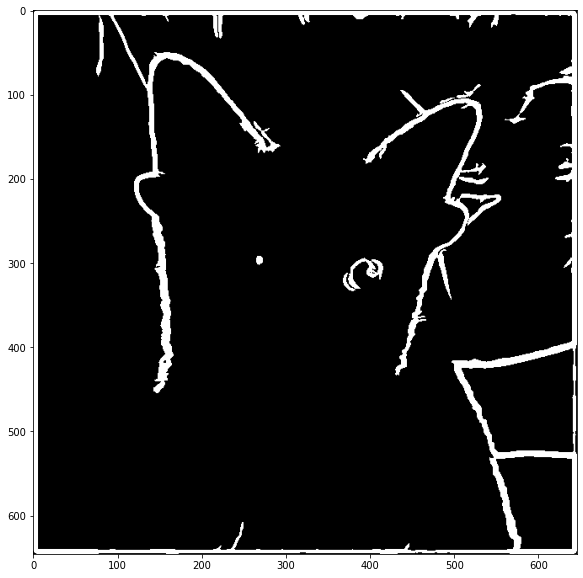

In [7]:
def dfs (img, visited, i, j, max_val):
    n = img.shape[0]*img.shape[1]
    stack = [(i, j)]
    while stack :
        si, sj = stack[-1]
        
        if not visited[si*img.shape[1] + sj]:
            visited[si*img.shape[1] + sj] = True
            for x in [-1, 0, 1]:
                for y in [-1, 0, 1]:
                    new_i = si + x
                    new_j = sj + y
                    if new_i < 0 or new_i >= img.shape[0] or new_j < 0 or new_j >= img.shape[1] or (visited[new_i*img.shape[1] + new_j] == True):
                        continue
                    if img[new_i, new_j] > 0:
                        img[new_i, new_j] = max_val
                        stack.append((new_i, new_j))
        else :
            stack.pop()
            
    return img, visited

def hysteresis(img, low_ratio, high_ratio):
    max_val = np.max(grad)

    Th_h = max_val * high_ratio
    Th_l = max_val *  low_ratio

    img[img <= Th_l] = 0
    img[img > Th_h] = max_val

    visited = [False]*(img.shape[0]*img.shape[1])
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if ((visited[i*img.shape[1]+j] == False) and img[i, j] == max_val):
                img, visited = dfs(img, visited, i, j, max_val) 
                
    img[img < Th_h] = 0
    return img



plt.figure("Hysterisis", figsize = figureSize)
hyst = hysteresis(grad, 0.1, 0.5)
# for i in range(hist.shape[0]):
#     for j in range(hist.shape[1]):
#         if not (hist[i, j] == maxval):
#             continue
#         for x in [-1, 0, 1]:
#             for y in [-1, 0, 1]:
#                 new_i = i + x
#                 new_j = j + y
#                 if new_i < 0 or new_i >= hist.shape[0] or new_j < 0 or new_j >= hist.shape[1] :
#                     continue
#                 if not (hist[new_i, new_j] == maxval or hist[new_i, new_j] == 0):
#                     print(new_i, new_j, i, j)
#                     print(hist[new_i, new_j], hist[i, j])
plt.imshow(hyst)

In [8]:
def median_filter(img, dim):
    y_size = img.shape[0]
    x_size = img.shape[1]
    retl = np.zeros((y_size, x_size)).tolist()
    for i in range(y_size):
        for j in range(x_size):
            y_min = max(0, i-dim//2)
            y_max = min(y_size-1, i+dim//2)
            x_min = max(0, j-dim//2)
            x_max = min(x_size-1, j+dim//2)
            tmp = (img[y_min:(y_max+1), x_min:(x_max+1)].ravel()).tolist()
            retl[i][j] = sorted(tmp)[len(tmp) // 2]
    return np.asarray(retl)


In [9]:
def edge_thin (magnitude, phase):
    y_size = magnitude.shape[0]
    x_size = magnitude.shape[1]
    magnitudel = magnitude.tolist()
    phasel = phase.tolist()
    retl = magnitudel.copy()
    for i in range(1, y_size-1):
        for j in range(1, x_size-1):
            if phasel[i][j] == 0:
                if(magnitudel[i][j+1] > magnitudel[i][j] or magnitudel[i][j-1] > magnitudel[i][j]):
                    retl[i][j] = 0
            elif phasel[i][j] == 45:
                if(magnitudel[i+1][j+1] > magnitudel[i][j] or magnitudel[i-1][j-1] > magnitudel[i][j]):
                    retl[i][j] = 0
            elif phasel[i][j] == 90:
                if(magnitudel[i+1][j] > magnitudel[i][j] or magnitudel[i-1][j] > magnitudel[i][j]):
                    retl[i][j] = 0
            else:
                if(magnitudel[i+1][j-1] > magnitudel[i][j] or magnitudel[i-1][j+1] > magnitudel[i][j]):
                    retl[i][j] = 0
    return np.asarray(retl)

6300.539269767983
6300.539269767983


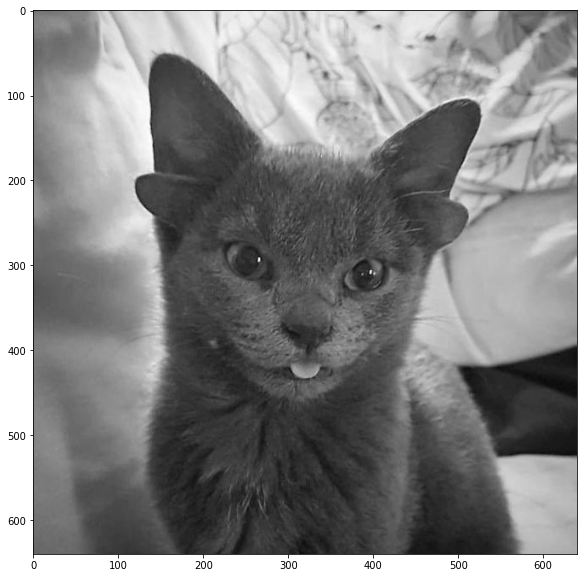

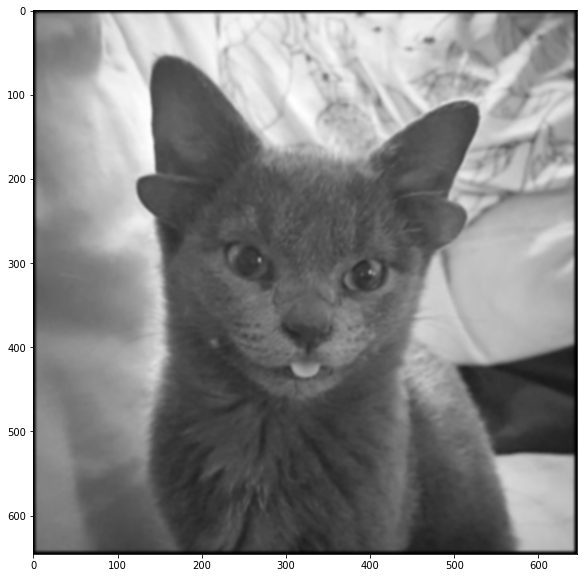

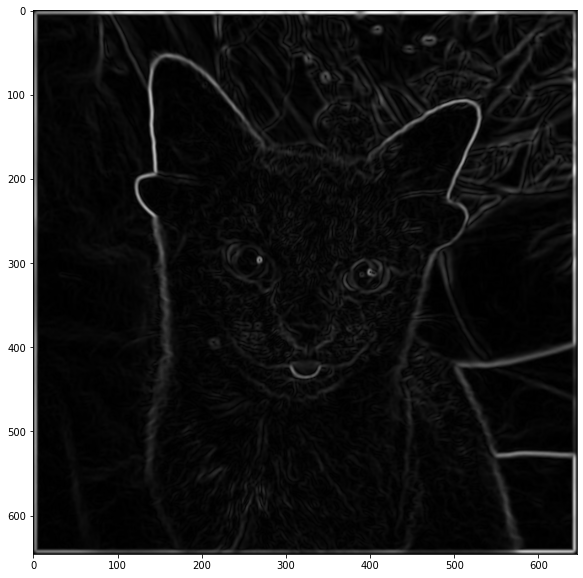

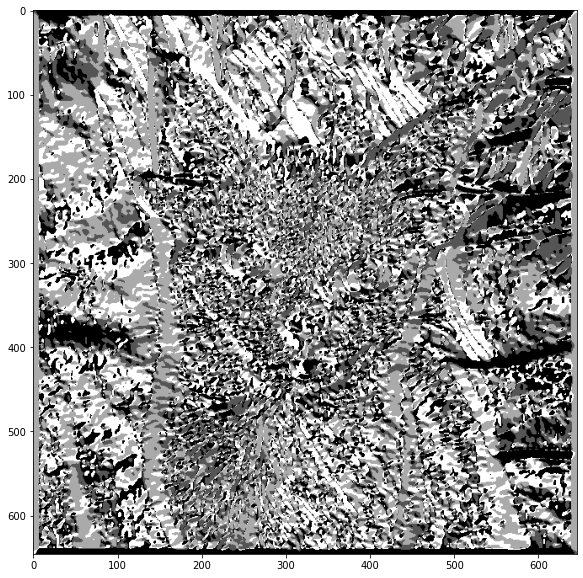

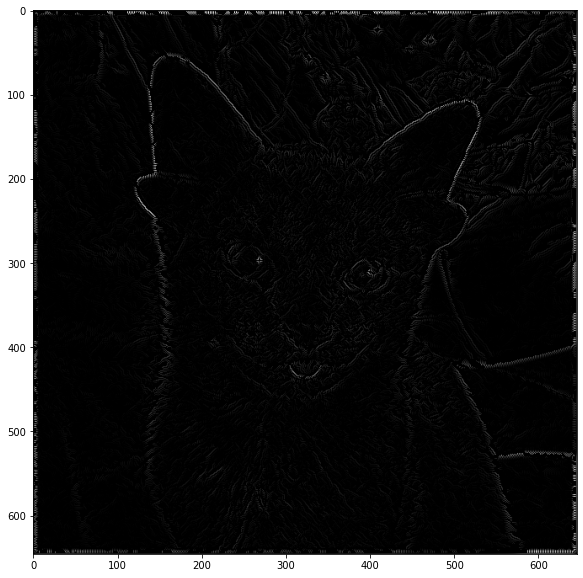

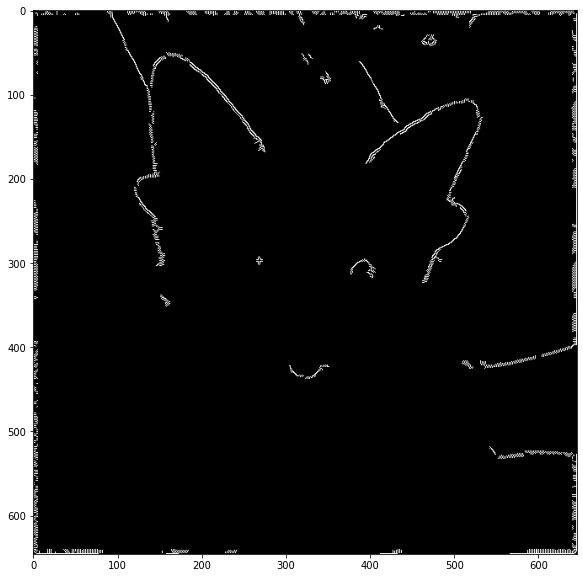

In [17]:
image = mpimg.imread("images/cat.jpeg")
image_gr = rgb2gray(image)

figureSize = (12,10)
plt.figure("Original Image", figsize=figureSize)
plt.imshow(image_gr)
plt.set_cmap("gray")

smooth_img = gaussian_smooth(image_gr, 7, 1.5)
plt.figure("Smoothed", figsize = figureSize)
plt.imshow(smooth_img)

plt.figure("Sobel Gradient", figsize = figureSize)
grad, phase = gradient_sobel(smooth_img)
plt.imshow(grad)

plt.figure("Sobel Phase", figsize = figureSize)
plt.imshow(phase)

thin_edge = edge_thin(grad, phase)
plt.figure("Thin edge", figsize = figureSize)
plt.imshow(thin_edge)

print(np.max(thin_edge))
plt.figure("Hysterisis", figsize = figureSize)
hyst = hysteresis(thin_edge, 0.1, 0.3)
maxval = np.max(hyst)
print(maxval)
plt.imshow(hyst)
